In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, regexp_replace
from pyspark import SparkFiles
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [39]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 2.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [3]:
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/1513/pg1513.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/23042/pg23042.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/27761/pg27761.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/1533/pg1533.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/1531/pg1531.txt")

In [4]:
df = spark.read.text(SparkFiles.get("pg1513.txt"))
df

DataFrame[value: string]

In [6]:
df.show()

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
|of the Project Gu...|
|at www.gutenberg....|
|you will have to ...|
|before using this...|
|                    |
|Title: Romeo and ...|
|                    |
|Author: William S...|
|                    |
|Release date: Nov...|
|                M...|
|                    |
|   Language: English|
|                    |
|Credits: the PG S...|
+--------------------+
only showing top 20 rows



In [7]:
df.printSchema()

root
 |-- value: string (nullable = true)



In [8]:
df.count()

5647

In [9]:
df.describe().show()

+-------+--------------------+
|summary|               value|
+-------+--------------------+
|  count|                5647|
|   mean|                NULL|
| stddev|                NULL|
|    min|                    |
|    max|’Twixt my extreme...|
+-------+--------------------+



In [10]:
df = df.withColumn("words", split(df["value"], " "))
df = df.withColumn("word", explode(df["words"]))
df= df.drop("value","words")
df.show()

+---------+
|     word|
+---------+
|      The|
|  Project|
|Gutenberg|
|    eBook|
|       of|
|    Romeo|
|      and|
|   Juliet|
|         |
|         |
|         |
|         |
|         |
|     This|
|    ebook|
|       is|
|      for|
|      the|
|      use|
|       of|
+---------+
only showing top 20 rows



In [11]:
df = df.withColumn("word", regexp_replace("word", "[^\w\s]", ""))
df.show()

+---------+
|     word|
+---------+
|      The|
|  Project|
|Gutenberg|
|    eBook|
|       of|
|    Romeo|
|      and|
|   Juliet|
|         |
|         |
|         |
|         |
|         |
|     This|
|    ebook|
|       is|
|      for|
|      the|
|      use|
|       of|
+---------+
only showing top 20 rows



In [12]:
df = df.withColumn("word", regexp_replace("word", "[^a-zA-Z0-9\\s]", ""))
df.show()

+---------+
|     word|
+---------+
|      The|
|  Project|
|Gutenberg|
|    eBook|
|       of|
|    Romeo|
|      and|
|   Juliet|
|         |
|         |
|         |
|         |
|         |
|     This|
|    ebook|
|       is|
|      for|
|      the|
|      use|
|       of|
+---------+
only showing top 20 rows



In [13]:
df=df.na.drop()
df.show()

+---------+
|     word|
+---------+
|      The|
|  Project|
|Gutenberg|
|    eBook|
|       of|
|    Romeo|
|      and|
|   Juliet|
|         |
|         |
|         |
|         |
|         |
|     This|
|    ebook|
|       is|
|      for|
|      the|
|      use|
|       of|
+---------+
only showing top 20 rows



In [14]:
df.count()

30688

In [15]:
df.groupBy("word").count().show()

+----------+-----+
|      word|count|
+----------+-----+
|    online|    4|
| Montagues|    8|
|       art|   51|
|     those|   15|
|        By|   31|
|     still|   13|
|      some|   45|
|     cures|    1|
|   Sitting|    1|
|      Nell|    1|
| solemnity|    3|
|     Aside|    3|
|     feign|    1|
|    Easter|    1|
|consortest|    1|
|   murderd|    2|
|    Taking|    2|
|    Heaven|    2|
|  Acquaint|    1|
|      earl|    1|
+----------+-----+
only showing top 20 rows



In [16]:
pandas_df=df.toPandas()

In [17]:
pandas_df

,word
0,The
1,Project
2,Gutenberg
3,eBook
4,of
...,...
30683,about
30684,new
30685,eBooks
30686,


In [20]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30688 entries, 0 to 30687
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    30688 non-null  object
dtypes: object(1)
memory usage: 239.9+ KB


In [18]:
pandas_df_string=pandas_df.to_string()

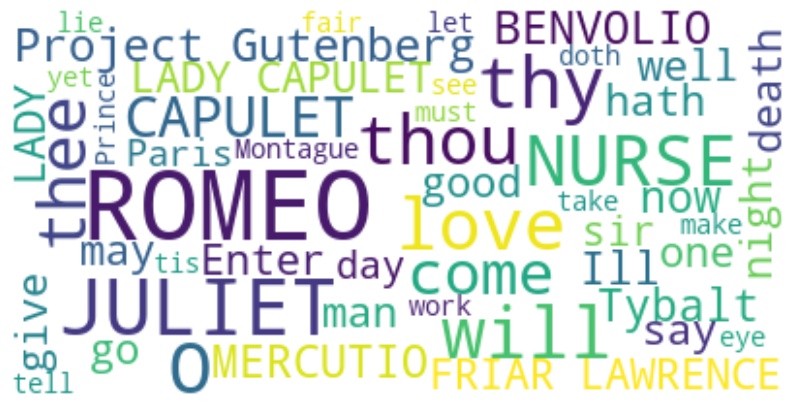

In [19]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(pandas_df_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

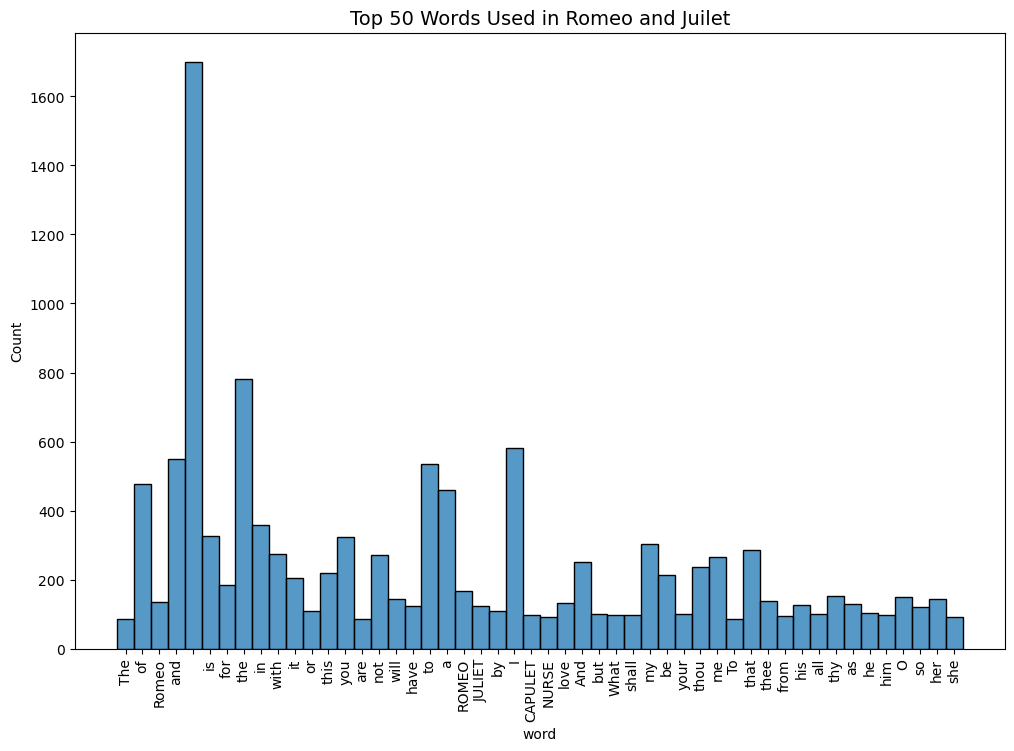

In [22]:
top_50 = pandas_df['word'].value_counts().nlargest(50).index
pandas_df_top50 = pandas_df[pandas_df['word'].isin(top_50)]
plt.figure(figsize=(12,8))
sns.histplot(data=pandas_df_top50,x='word')
plt.title('Top 50 Words Used in Romeo and Juilet',fontsize=14)
plt.xticks(rotation=90)
plt.show()